# Title : Forest Cover type Prediction
- 북 콜로라도에 위치한 국립 루즈벨트 공원에 존재하는 4개의 황야지대의 숲데이터셋이 주어진다. 
- 각 데이터셋의 데이터 포인트들은 30제곱미터를 기준으로 한다. 
- 데이터셋을 토대로 숲의 특성으로부터 숲의 나무 종류를 분류하는 것이 목적이다. 

In [1]:
import sklearn
import pandas as pd
import numpy as np
import mglearn
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from IPython.display import display

In [2]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [3]:
train_id = train.Id
test_id = test.Id
# Id 삭제 
train.drop('Id', axis = 1, inplace=True)
test.drop('Id', axis = 1, inplace=True)

print('train_data shape', train.shape)
print('test_data shape', test.shape)

train_data shape (15120, 55)
test_data shape (565892, 54)


## 변수 설명
- Elevation - Elevation in meters (높이 /meter 단위)
- Aspect - Aspect in degrees azimuth (방위각)
- Slope - Slope in degrees (기울기 각도 /도 단위)
- Horizontal_Distance_To_Hydrology - Horz Dist to nearest surface water features (수원과의 수평거리)
- Vertical_Distance_To_Hydrology - Vert Dist to nearest surface water features (수원과의 수직거리)
- Horizontal_Distance_To_Roadways - Horz Dist to nearest roadway (길가와의 수평거리)
- Hillshade_9am (0 to 255 index) - Hillshade index at 9am, summer solstice (오전 9시의 차양 / 0~255)
- Hillshade_Noon (0 to 255 index) - Hillshade index at noon, summer solstice (정오시의 차양/ 0~255)
- Hillshade_3pm (0 to 255 index) - Hillshade index at 3pm, summer solstice (오후 9시의 차양/ 0~255)
- Horizontal_Distance_To_Fire_Points - Horz Dist to nearest wildfire ignition points (야생 산불 발화지점과의 수평거리)
- Wilderness_Area (4 binary columns, 0 = absence or 1 = presence) - Wilderness area designation (황야 지대 /4종류 ) in Roosevelt National Forest of northern Colorado
- Soil_Type (40 binary columns, 0 = absence or 1 = presence) - Soil Type designation (토양 종류 / 40종류)

- 토양종류와 황야 지대 카테고리별 설명은 https://www.kaggle.com/c/forest-cover-type-prediction/data 참조


## 종속 변수
- Cover_Type (7 types, integers 1 to 7) - Forest Cover Type designation- (산림 유형 / 7종류) (the predominant kind of tree cover)
- 1 - Spruce/Fir
- 2 - Lodgepole Pine
- 3 - Ponderosa Pine
- 4 - Cottonwood/Willow
- 5 - Aspen
- 6 - Douglas-fir
- 7 - Krummholz

In [27]:
# 독립변수와 종속변수 나누기
train_data = train.iloc[:, :-1]
train_target = train.iloc[:, -1]
# train 데이터 갯수 저장
ntrain = len(train)

# train, test데이터 합쳐서 같이 feature engineering
all_data = pd.concat([train_data, test])
print('all_data shape', all_data.shape)

all_data shape (581012, 54)


# 시각화 by ViolinPlot

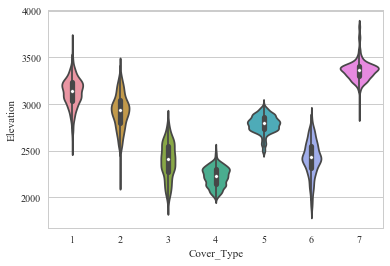

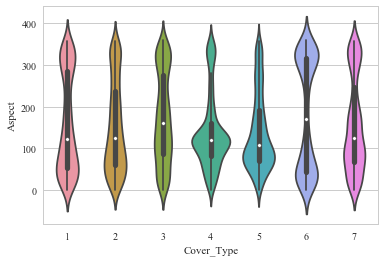

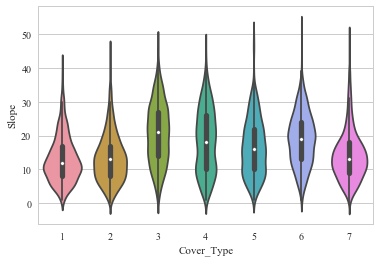

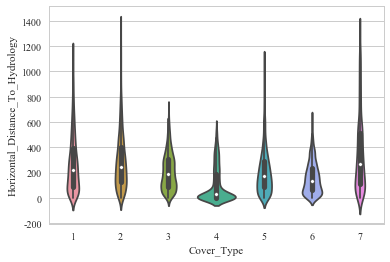

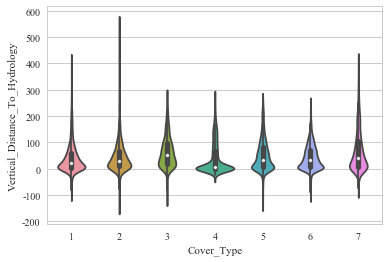

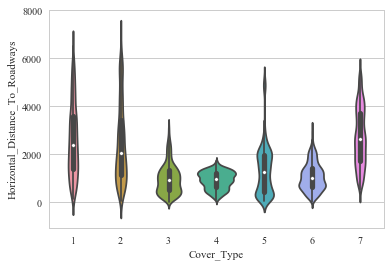

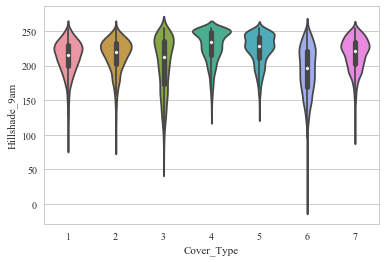

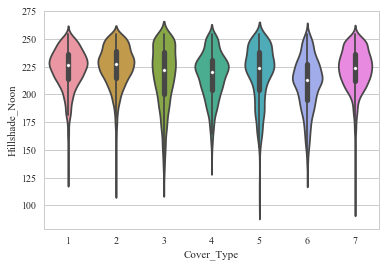

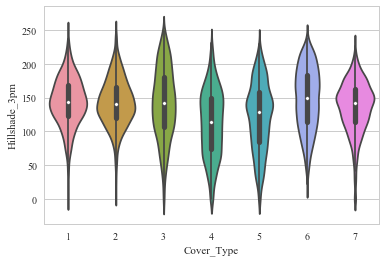

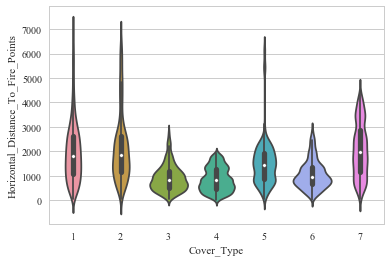

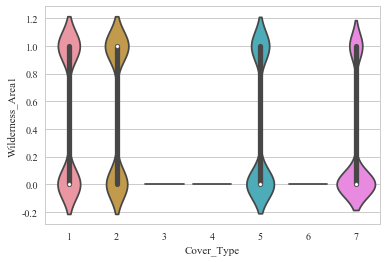

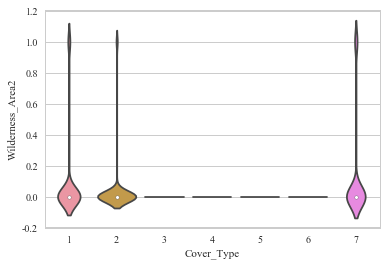

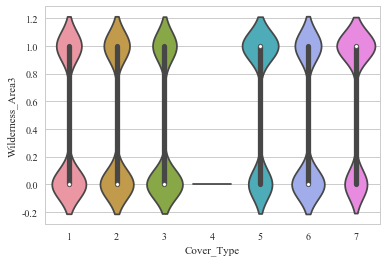

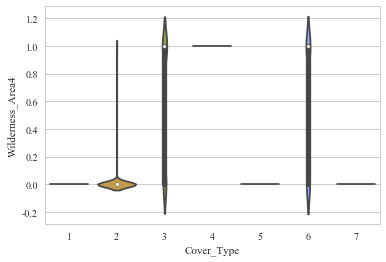

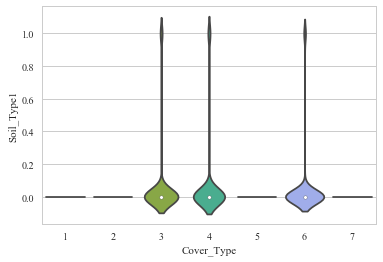

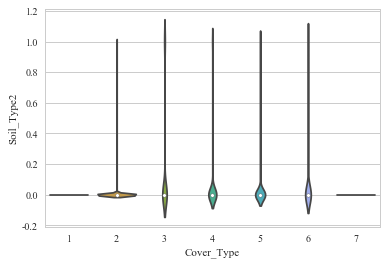

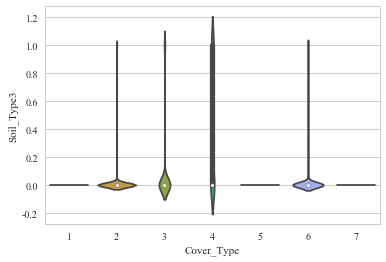

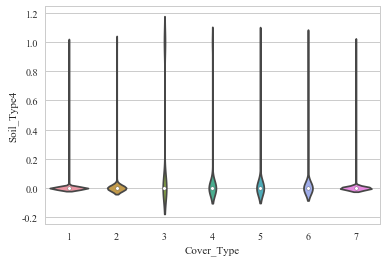

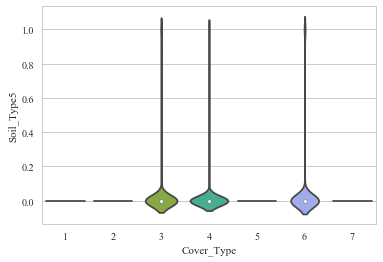

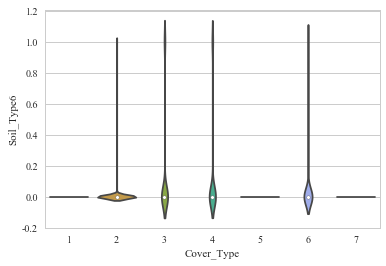

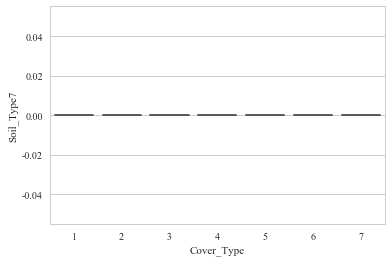

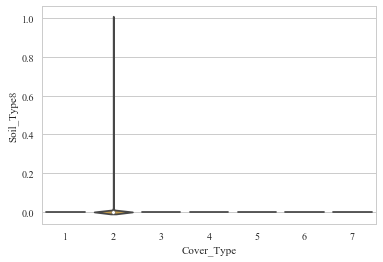

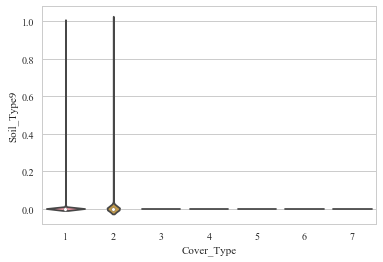

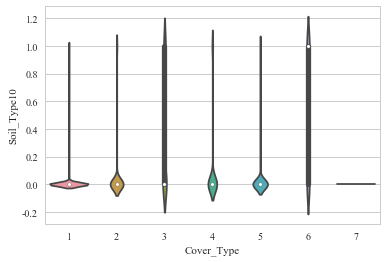

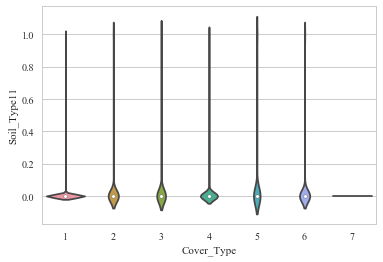

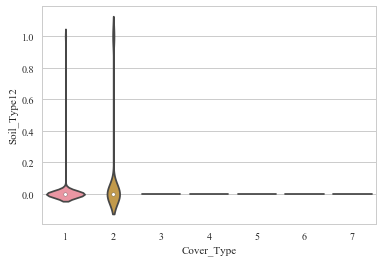

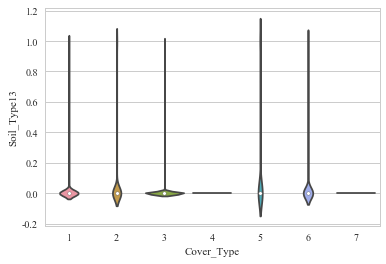

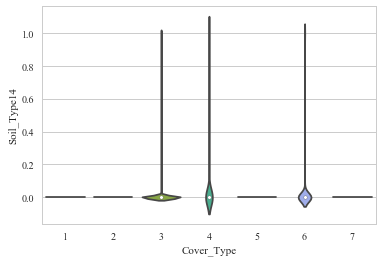

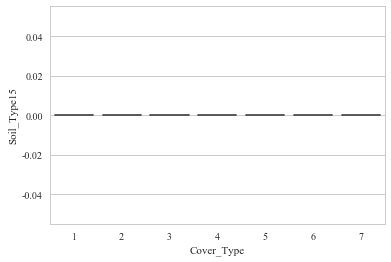

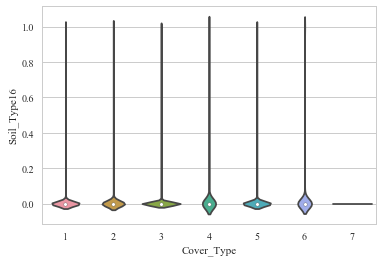

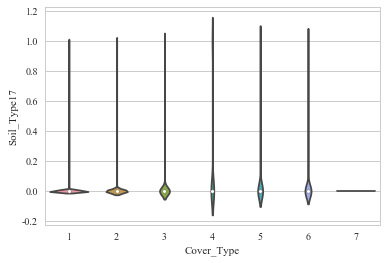

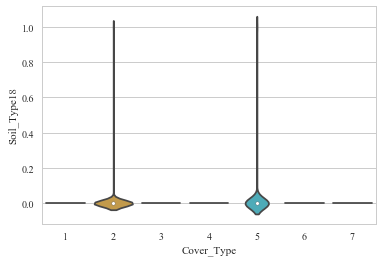

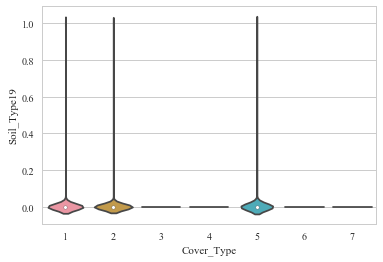

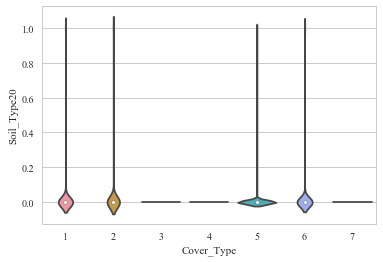

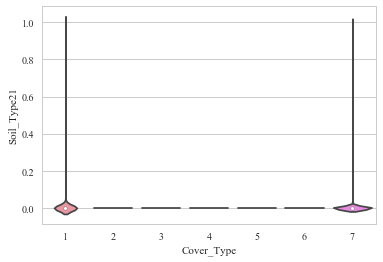

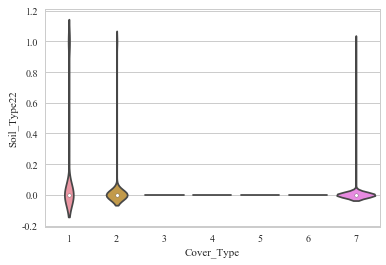

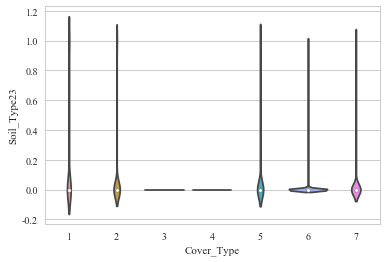

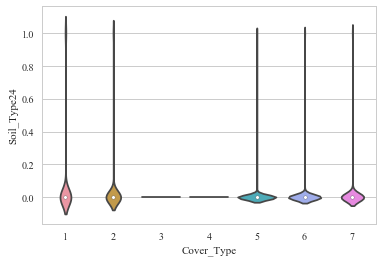

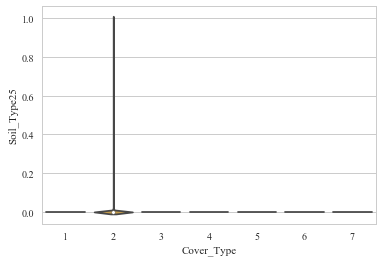

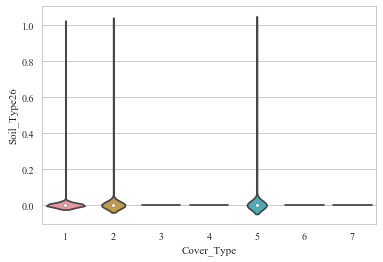

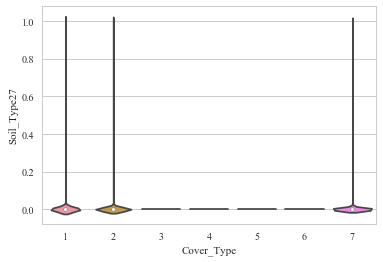

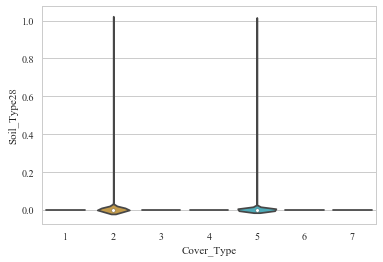

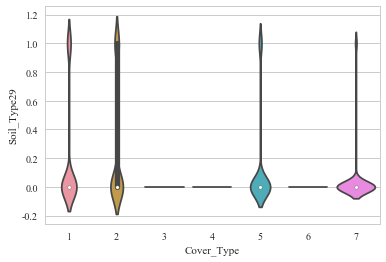

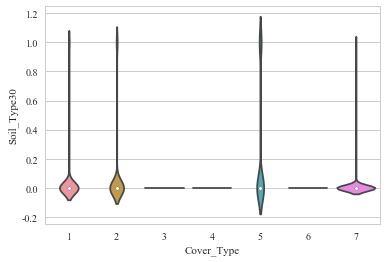

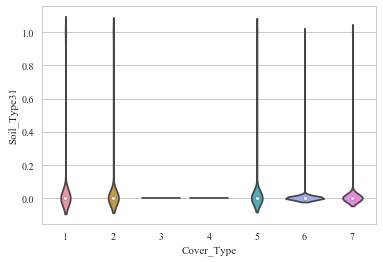

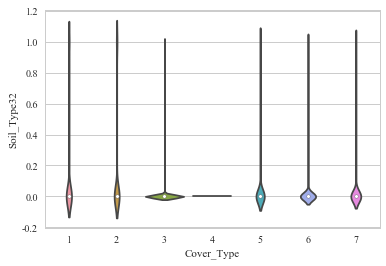

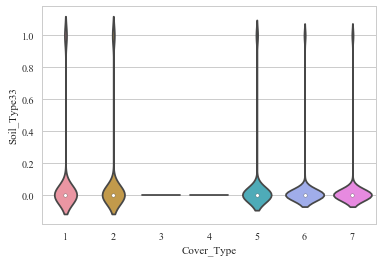

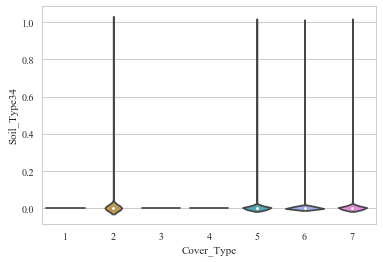

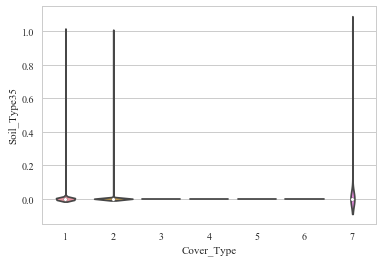

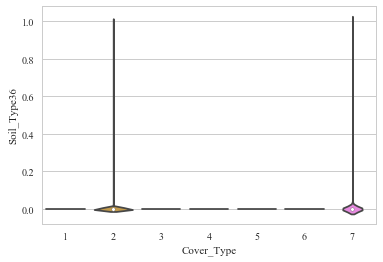

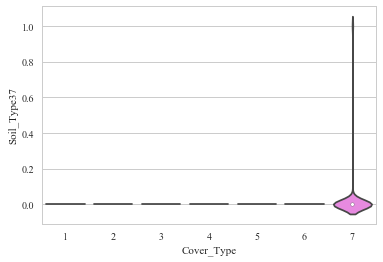

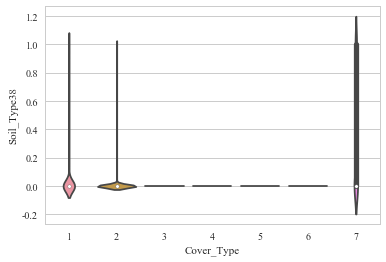

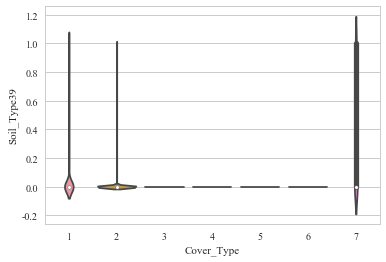

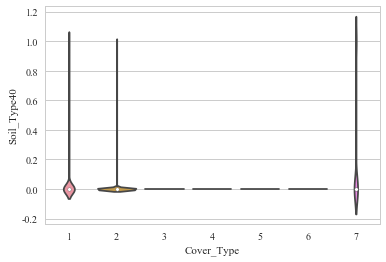

In [5]:
for i in range(train.shape[1] - 1):
    sns.violinplot(train.iloc[:, -1] ,y=train.iloc[:, i])
    plt.show()

# type 변수들 관찰
- Soil_type7, 8, 15, 25는 훈련데이터에서 한 카테고리가 1 이하로 나왔으므로 의미가 없다. 

In [28]:
train.loc[:, 'Wilderness_Area1':'Cover_Type'].sum(axis = 0)

Wilderness_Area1     3597
Wilderness_Area2      499
Wilderness_Area3     6349
Wilderness_Area4     4675
Soil_Type1            355
Soil_Type2            623
Soil_Type3            962
Soil_Type4            843
Soil_Type5            165
Soil_Type6            650
Soil_Type7              0
Soil_Type8              1
Soil_Type9             10
Soil_Type10          2142
Soil_Type11           406
Soil_Type12           227
Soil_Type13           476
Soil_Type14           169
Soil_Type15             0
Soil_Type16           114
Soil_Type17           612
Soil_Type18            60
Soil_Type19            46
Soil_Type20           139
Soil_Type21            16
Soil_Type22           345
Soil_Type23           757
Soil_Type24           257
Soil_Type25             1
Soil_Type26            54
Soil_Type27            15
Soil_Type28             9
Soil_Type29          1291
Soil_Type30           725
Soil_Type31           332
Soil_Type32           690
Soil_Type33           616
Soil_Type34            22
Soil_Type35 

In [30]:
drop_columns = ['Soil_Type7', 'Soil_Type15']

In [29]:
train.iloc[:,:10].shape

(15120, 10)

In [31]:
all_data.drop(drop_columns, axis = 1, inplace = True)

In [32]:
train_data = all_data[:ntrain]
test = all_data[ntrain:]
print(train_data.shape)
print(test.shape)

(15120, 52)
(565892, 52)


# Feature Selection By Model
- XGB
- RandomForest
- ExtraTreeClassifier
- GradientBoost

In [33]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import *

In [34]:
def cv_score(model, train_data, train_target):
    cv = KFold(n_splits=5, shuffle = True, random_state = 42).get_n_splits(train_data.values)
    return cross_val_score(model, train_data, train_target, scoring='accuracy', cv= cv)

- 각 스케일러 별로 모델들을 학습시켜 importance들의 리스트를 구한다.
- 평균을 내어서 순위를 매겨 가장 높은 중요도를 가진 feature들로 정렬한다. 

In [36]:
# RandomForest
rf = RandomForestClassifier(n_estimators=300, max_depth=15, min_samples_leaf=2, random_state=42, n_jobs=-1)
# extra
extra = ExtraTreesClassifier(n_estimators=300, max_depth=15, min_samples_leaf=2, random_state=42, n_jobs=-1)

In [37]:
rf.fit(train_data, train_target)
extra.fit(train_data, train_target)

model_names = ['RandomForest', 'ExtraTree']
importances = [rf.feature_importances_, extra.feature_importances_]

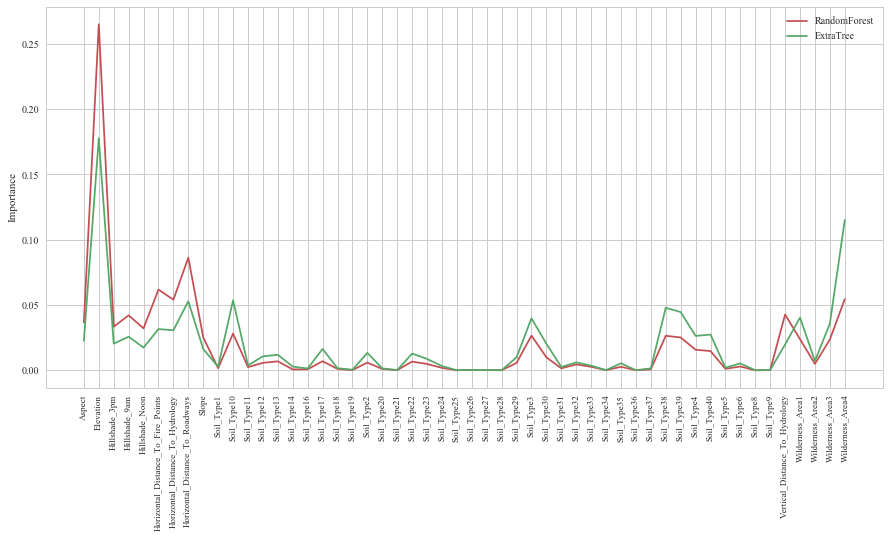

In [39]:
plt.figure(figsize = (15, 7))

for color, importance in zip(['r','g'], importances):
    plt.plot(range(52), importance, c= color)
    ax = plt.gca()
    ax.set_xticks(range(52))
    ax.set_xticklabels(train_data.columns, fontdict={'fontsize': 9, 'rotation': 'vertical'})
    plt.ylabel('Importance')
plt.legend(model_names, loc='best')

In [40]:
feature_importances = pd.Series(np.array(importances).sum(axis = 0), index = train_data.columns).sort_values(ascending=False)
print(feature_importances.head())
importance_rank = feature_importances.index

Elevation                             0.442576
Wilderness_Area4                      0.169482
Horizontal_Distance_To_Roadways       0.139068
Horizontal_Distance_To_Fire_Points    0.093326
Horizontal_Distance_To_Hydrology      0.084630
dtype: float64


# Feature Selection
- feature selection의 성과를 측정해보기 위해 가장 높은 순위부터 1, 0.75, 0.5, 0.25 만큼 feature selection한 것을 각각 평가한다.

In [41]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import make_pipeline
import tensorflow as tf

In [42]:
feature_select= [1.0, 0.75, 0.5, 0.25]
feature_select_names = ['all', '3/4', 'half', '1/4']

In [43]:
train_data.shape

(15120, 52)

In [47]:
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
category_data = train_data.iloc[:, 10:]

robust_scaled = RobustScaler().fit_transform(train_data.iloc[:,:10])
standard_scaled = StandardScaler().fit_transform(train_data.iloc[:,:10])
minmax_scaled = MinMaxScaler().fit_transform(train_data.iloc[:,:10])

robust_data = pd.concat([pd.DataFrame(robust_scaled, columns = train_data.columns[:10]), category_data], axis=1)
standard_data = pd.concat([pd.DataFrame(standard_scaled, columns = train_data.columns[:10]), category_data], axis=1)
minmax_data = pd.concat([pd.DataFrame(minmax_scaled, columns = train_data.columns[:10]), category_data], axis=1)

scaled_data_list = [robust_data, standard_data, minmax_data]

In [50]:
for name, ratio in zip(feature_select_names, feature_select):
    selected_data = standard_data[importance_rank[: int(len(importance_rank) * ratio)]]
    svc = make_pipeline(StandardScaler(), SVC(C=1000, gamma = 0.1))

    xgb =  XGBClassifier(n_estimators=400, max_depth=7, min_child_weight=4, objective='multi:softmax', nthread = -1)

    rf = RandomForestClassifier(n_estimators=300, max_depth=15, min_samples_leaf=2, random_state=42, n_jobs=-1)

    extra = ExtraTreesClassifier(n_estimators=300, max_depth=15, min_samples_leaf=2, random_state=42, n_jobs=-1)

    gboost = GradientBoostingClassifier(n_estimators=400, max_depth=7)
    print('Test :', name)
    print()
    score = cv_score(svc, selected_data , train_target)
    print(score)
    print('SVC : {:.4f}({:.4f})'.format(score.mean(), score.std()))

    score = cv_score(xgb, selected_data , train_target)
    print(score)
    print('xgb : {:.4f}({:.4f})'.format(score.mean(), score.std()))

    score = cv_score(rf, selected_data , train_target)
    print('\n',score)
    print('rf : {:.4f}({:.4f})'.format(score.mean(), score.std()))

    score = cv_score(extra, selected_data , train_target)
    print('\n',score)
    print('Extra : {:.4f}({:.4f})'.format(score.mean(), score.std()))

    score = cv_score(gboost, selected_data , train_target)
    print('\n',score)
    print('GBoost : {:.4f}({:.4f})'.format(score.mean(), score.std()))
    print('---------------------------------------------------------------------------------------------------------')

Test : all

[ 0.71494709  0.72685185  0.70634921  0.72519841  0.8098545 ]
SVC : 0.7366(0.0374)
[ 0.76686508  0.74470899  0.7609127   0.78306878  0.84589947]
xgb : 0.7803(0.0350)

 [ 0.71792328  0.71428571  0.74239418  0.78670635  0.82109788]
rf : 0.7565(0.0414)

 [ 0.66236772  0.68022487  0.7093254   0.73941799  0.79100529]
Extra : 0.7165(0.0455)

 [ 0.77678571  0.75132275  0.7797619   0.79232804  0.85449735]
GBoost : 0.7909(0.0345)
---------------------------------------------------------------------------------------------------------
Test : 3/4

[ 0.71494709  0.7228836   0.70469577  0.7255291   0.80588624]
SVC : 0.7348(0.0363)
[ 0.76818783  0.74272487  0.76455026  0.78207672  0.8452381 ]
xgb : 0.7806(0.0347)

 [ 0.71957672  0.72056878  0.74636243  0.79034392  0.82837302]
rf : 0.7610(0.0423)

 [ 0.6656746   0.68154762  0.71494709  0.7473545   0.79695767]
Extra : 0.7213(0.0472)


KeyboardInterrupt: 

## Feature Selection/ Model selection 결과
- feature selection 결과 특정모델(Randomforest, SVC)은 아주 미세하게 퍼포먼스가 좋아질 때도 있었지만 전체적으로 CV score는 낮아지는 것을 볼 수 있다.
- Gboost > XGBoost > RandomForest > ExtraTree > SVC 순으로 성과가 좋았다. 

# Model Selection & Validation

# 1. Model Selection</n>
## 1) 비교대상 
- DecisionTreeClassifier
- ExtraTreesClassifier
- RandomForestClassifier
- GradientBoostingClassifier
- XGBClassifier
- SVC (support vector machine)

## 2) 비교 방법 
- Cross-Validation (test size 0.3, f1_score)

In [5]:
%%time
#cross validation between decision tree, extra tree, random forest, g boost, xg boost, svc
#add training data (cover type 1,2)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import*
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
standard_scaler = StandardScaler()

train = pd.read_csv('./train.csv').iloc[:, 1:]
dfX = train.iloc[:, :-1]
dfy = train.iloc[:, [-1]]

num = 5 #교차검증 횟수
#결과를 저장할 리스트
re_tree = []
re_extra = []
re_xg = []
re_svc = []
re_gb = []
re_random = []

#hyper parameters for decision tree, random forest, xg boost, g-boost, extra
n_es = 200 #n_estimator
m_d = 10 # max_depth

for i in range(num):
    X_train, X_test, y_train, y_test = train_test_split(dfX, dfy, test_size=0.3)
    simple_tree = DecisionTreeClassifier(criterion = 'entropy', max_depth=m_d).fit(X_train, y_train)
    extra = ExtraTreesClassifier(max_depth=m_d, n_estimators=n_es).fit(X_train, y_train.values.ravel())
    random = RandomForestClassifier(n_estimators=n_es, max_depth=m_d).fit(X_train, y_train.values.ravel())
    xg = XGBClassifier(n_estimators=n_es, learning_rate=0.1, max_depth=m_d, objective='multi:softmax') 
    g_boost = GradientBoostingClassifier(n_estimators=n_es, max_depth=m_d).fit(X_train, y_train.values.ravel())
    result = xg.fit(X_train, y_train.values.ravel())
    model_svc = make_pipeline(StandardScaler(), SVC(C=1000, gamma = 0.1)).fit(X_train, y_train.values.ravel())
    pred_y1 = simple_tree.predict(X_test)
    pred_y2 = extra.predict(X_test)
    pred_y3 = result.predict(X_test)
    pred_y4 = model_svc.predict(X_test)
    pred_y5 = random.predict(X_test)
    pred_y6 = g_boost.predict(X_test)
    #print(tree1.feature_importances_)
    
    print('[simple decision tree]', i )
    print(classification_report(y_test, pred_y1, target_names = ['1', '2', '3', '4', '5', '6', '7']))
    re_tree.append(accuracy_score(y_test, pred_y1))
    re_extra.append(accuracy_score(y_test, pred_y2))
    print('[extra tree]', i )
    print(classification_report(y_test, pred_y2, target_names = ['1', '2', '3', '4', '5', '6', '7']))
    re_xg.append(accuracy_score(y_test, pred_y3))
    print('[xgboost]', i )
    print(classification_report(y_test, pred_y3, target_names = ['1', '2', '3', '4', '5', '6', '7']))
    re_svc.append(accuracy_score(y_test, pred_y4))
    print('[svc]', i )
    print(classification_report(y_test, pred_y4, target_names = ['1', '2', '3', '4', '5', '6', '7']))
    re_random.append(accuracy_score(y_test, pred_y5))
    re_gb.append(accuracy_score(y_test, pred_y6))
    print('[g_boost]', i )
    print(classification_report(y_test, pred_y6, target_names = ['1', '2', '3', '4', '5', '6', '7']))
    print('[random forest]', i )
    print(classification_report(y_test, pred_y5, target_names = ['1', '2', '3', '4', '5', '6', '7']))

print('[simple decision tree]')
print(np.mean(re_tree), np.std(re_tree))
print('[ExtraTrees]')
print(np.mean(re_extra), np.std(re_random))
print('[Random Forest]')
print(np.mean(re_random), np.std(re_random))
print('[Gradiant boost]')
print(np.mean(re_gb), np.std(re_random))
print('[xgboost]')
print(np.mean(re_xg), np.std(re_xg))
print('[SVC]')
print(np.mean(re_svc), np.std(re_svc))

[simple decision tree] 0
             precision    recall  f1-score   support

          1       0.66      0.66      0.66       676
          2       0.64      0.46      0.53       670
          3       0.77      0.58      0.66       645
          4       0.90      0.94      0.92       599
          5       0.74      0.92      0.82       637
          6       0.68      0.80      0.74       645
          7       0.86      0.94      0.90       664

avg / total       0.75      0.75      0.74      4536

[extra tree] 0
             precision    recall  f1-score   support

          1       0.67      0.67      0.67       676
          2       0.65      0.52      0.58       670
          3       0.74      0.62      0.68       645
          4       0.76      0.97      0.86       599
          5       0.68      0.86      0.76       637
          6       0.73      0.65      0.68       645
          7       0.91      0.90      0.91       664

avg / total       0.74      0.74      0.73      4536



[simple decision tree] 3
             precision    recall  f1-score   support

          1       0.66      0.73      0.69       648
          2       0.69      0.56      0.62       641
          3       0.69      0.65      0.67       647
          4       0.92      0.92      0.92       666
          5       0.82      0.86      0.84       667
          6       0.66      0.72      0.69       604
          7       0.90      0.88      0.89       663

avg / total       0.76      0.76      0.76      4536

[extra tree] 3
             precision    recall  f1-score   support

          1       0.67      0.66      0.67       648
          2       0.69      0.55      0.61       641
          3       0.75      0.61      0.67       647
          4       0.78      0.96      0.86       666
          5       0.70      0.85      0.77       667
          6       0.68      0.67      0.67       604
          7       0.90      0.88      0.89       663

avg / total       0.74      0.74      0.74      4536



 - cross-validation 결과 g-boost와 xg-boost가 비교적 높은 성능을 보임.
 - 사용한 Classifier와 상관없이 Cover_type 1,2에 대한 스코어가 가장 낮음. 
 - <b>수행 시간을 고려하여 xg-boost 사용을 결정함.</b>

# 2. Initial Performance (by submission)

In [ ]:
# submit based validation
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
train = pd.read_csv('./train.csv').iloc[:, 1:]
dfX = train.iloc[:, :-1]
dfy = train.iloc[:, [-1]]

model = XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=10, objective='multi:softmax') 
result = model.fit(dfX, dfy.values.ravel())

#predict
test = pd.read_csv('./test.csv').iloc[:, 1:]
test_y = result.predict(test)
test_y = pd.DataFrame(test_y)

#submit file 생성
ids = pd.read_csv('./test.csv').iloc[:, :1]
submit = pd.concat([ids, test_y], axis=1)
submit.columns = ['Id', 'Cover_Type']
submit_group = submit.groupby('Cover_Type')
print(submit_group.count())
submit.to_csv("./InitialSubmission.csv", ',', index=False)


![python image](1.png)

## 중간 결과
- 별도의 Feature Engineering을 거치지 않고 실행하였을 때, 어느 이상 결과가 올라가지 않는 것을 관찰할 수 있었음.
- kaggle 제출 기록을 보아 1번 클래스와 2번 클래스가 현저하게 많은 것을 관찰할 수 있었다. 
- 추가적인 확인 결과 1번 클래스의 스프루스 수종과, 2번 클래스의 파인 수종은 콜로라도 주에서 가장 많은 수를 가지고 있는 수종이었음.
- 또한 스프루스와 파인은 나무의 특성이 비슷하여 실제로도 구분이 어렵다고 함.


# 3. Performance 향상

## 가설 : Sample 데이터에 문제가있다. (Training Data, Test Data간의 차이점) 
### 데이터 갯수
- 만오천개의 데이터로 Training 하여, 56만개의 Test Data에 대한 예측을 수행하여야함. 

### 종속변수 Class
- Training Data는 만오천개의 데이터가 종속변수(Cover_Type) Class 1~7에 균등하게 분포함. (2160 * 7)
- 이에 반해 0.75의 Score를 기록한 초기 모델로 56만개의 Test Data에 대한 예측을 수행한결과 <br />
  <b>Cover_Type이 1,2에 치중됨. (약 100 : 110 : 15 : 1 : 15 : 10 : 15)</b>
  
### 실험 : Over-sampling을 통해 성능이 향상되는지 확인해보자 
- Test size : 0.3 > 0.7
- 교차검증을 위한 Train, Test 데이터 분리 후 Train 데이터만 Cover_Type 1, 2를 중복생성 했을때 성능이 향상되는지 확인.

In [43]:
%%time
#Simple Cross-validation
from sklearn.model_selection import train_test_split
from sklearn.metrics import*
from xgboost import XGBClassifier


def merge(df, count):
    if count >= 1: ###cover type 1,2를 얼마만큼 중복생성할 것인지 결정.### 
        return df
    add_1 = train.loc[train['Cover_Type'] == 1]
    add_2 = train.loc[train['Cover_Type'] == 2]
    new_df = pd.concat([add_1, add_2, df], axis=0)
    return merge(new_df, count+1)

train = pd.read_csv('./train.csv').iloc[:, 1:]
dfX = train.iloc[:, :-1]
dfy = train.iloc[:, [-1]]

num = 5 #교차검증 횟수
#결과를 저장할 리스트
re_xg = []

#hyper parameters for decision tree, random forest, xg boost
n_es = 200
m_d = 10

for i in range(num):
    X_train, X_test, y_train, y_test = train_test_split(dfX, dfy, test_size=0.7)
    #train, test 데이터가 분리된 상태에서 train 데이터에 대해서만 covertype 1,2 추가 
    new_train = pd.concat([X_train, y_train], axis=1)
    new_train = merge(new_train, 0)
    X_train = new_train.iloc[:, :-1]
    y_train = new_train.iloc[:, [-1]]
    
    xg = XGBClassifier(n_estimators=n_es, learning_rate=0.1, max_depth=m_d, objective='multi:softmax') 
    result = xg.fit(X_train, y_train.values.ravel())
    
    pred_y3 = result.predict(X_test)
    re_xg.append(accuracy_score(y_test, pred_y3))
    
    print('[xgboost]', i )
    print(classification_report(y_test, pred_y3, target_names = ['1', '2', '3', '4', '5', '6', '7']))

print('[xgboost]')
print(np.mean(re_xg), np.std(re_xg))


[xgboost] 0
             precision    recall  f1-score   support

          1       0.89      1.00      0.94      1542
          2       0.80      1.00      0.89      1525
          3       0.80      0.76      0.78      1508
          4       0.93      0.95      0.94      1480
          5       0.98      0.81      0.89      1504
          6       0.81      0.77      0.79      1525
          7       1.00      0.87      0.93      1500

avg / total       0.89      0.88      0.88     10584

[xgboost] 1
             precision    recall  f1-score   support

          1       0.88      1.00      0.94      1526
          2       0.81      1.00      0.90      1486
          3       0.80      0.77      0.78      1490
          4       0.94      0.96      0.95      1523
          5       0.98      0.82      0.90      1514
          6       0.82      0.77      0.79      1501
          7       1.00      0.88      0.93      1544

avg / total       0.89      0.89      0.88     10584

[xgboost] 2
    

### 실험 결과 
- Test size 0.3 > 0.7 변경 (0.860/0.0050 > 0.818/0.0017)
- Cover_Type 1,2 중복생성 (0.818/0.0017 > 0.882/0.0025)
- <b>Over-sampling이 도움이된다는 가정하에 submission을 통해 최종 확인</b>

# 4. 결과 확인 
- SMOTEENN 방식으로 training 데이터 추가 생성 
- 생성 시 class별 비율은 초기 모델 예측결과에 기반하여 설정함.
- r = {1:230000, 2 : 240000, 3 : 30000, 4 : 2200, 5 : 10000, 6 : 20000, 7 : 20000}

In [45]:
from imblearn.combine import *
train = pd.read_csv('./train.csv').iloc[:, 1:]
r = {1:230000, 2 : 240000, 3 : 30000, 4 : 2200, 5 : 10000, 6 : 20000, 7 : 20000}
dfX = train.iloc[:, :-1]
dfy = train.iloc[:, [-1]]

sme = SMOTEENN(ratio = r, random_state=42)
X_res, y_res = sme.fit_sample(dfX, dfy.values.ravel())

/Users/seungminbaek/.pyenv/versions/3.6.1/envs/dss/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (230000) in class 1 will be larger than the number of samples in the majority class (class #5 -> 2160)
  n_samples_majority))
/Users/seungminbaek/.pyenv/versions/3.6.1/envs/dss/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (240000) in class 2 will be larger than the number of samples in the majority class (class #5 -> 2160)
  n_samples_majority))
/Users/seungminbaek/.pyenv/versions/3.6.1/envs/dss/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (30000) in class 3 will be larger than the number of samples in the majority class (class #5 -> 2160)
  n_samples_majority))
/Users/seungminbaek/.pyenv/versions/3.6.1/envs/dss/lib/python3.6/site-packages/imblearn/utils/validation.py:224: Use

551239
551239
[229957 239958  29851   1826   9819  19867  19961]


In [47]:
print('X :' , len(X_res))
print('y :' , len(y_res))
y_res_c = y_res - 1
print(np.bincount(y_res_c))

X : 551239
y : 551239
[229957 239958  29851   1826   9819  19867  19961]


### Hyper parameter tuning 
- Try & error로 반복 수행 (kaggle 제출 50번..)


In [49]:
# submit based validation
#from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

model = XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=10, objective='multi:softmax') 
result = model.fit(X_res, y_res)

#predict
test = pd.read_csv('./test.csv').iloc[:, 1:]
test_y = result.predict(test.values)
test_y = pd.DataFrame(test_y)

#submit file 생성
ids = pd.read_csv('./test.csv').iloc[:, :1]
submit = pd.concat([ids, test_y], axis=1)
submit.columns = ['Id', 'Cover_Type']
submit_group = submit.groupby('Cover_Type')
print(submit_group.count())
submit.to_csv("./FinalSubmission.csv", ',', index=False)

                Id
Cover_Type        
1           213711
2           248698
3            35666
4             1289
5            19021
6            21749
7            25758


![python image](3.png)

# 성능향상에 도움이 되지 않았던 시도들...
- 교호작용 반영하기 위한 전처리 (PolynomialFeatures)

In [35]:
from sklearn.preprocessing import PolynomialFeatures
def poly(dfX):
    poly = PolynomialFeatures(degree = 2, interaction_only=True, include_bias=False)
    dfX_poly = poly.fit_transform(dfX.iloc[:,:10])
    dfX_new = pd.DataFrame(dfX_poly,columns=poly.get_feature_names())
    dfX_add = dfX.iloc[:, 10:]
    #dfX_new = pd.concat([dfX_new, dfX_add], axis=1)
    dfX_new = pd.DataFrame(np.hstack([dfX_new.values, dfX_add.values]))
    return dfX_new

- Tensorflow를 활용한 Deeplearning 

In [ ]:
class NN_Model:

    def __init__(self, sess, name, learning_rate = 0.01):
        self.sess = sess
        self.name = name
        self._build_net()
        self.learning_rate = learning_rate

    def _build_net(self):
        with tf.device('/gpu:0'):
            with tf.variable_scope(self.name):
                # dropout (keep_prob) rate  0.7~0.5 on training, but should be 1
                # for testing
                self.keep_prob = tf.placeholder(tf.float32)
                nb_classes=7
                self.X = tf.placeholder(tf.float32, [None, 52])
                self.Y = tf.placeholder(tf.float32, [None, 7])

                W1 = tf.get_variable("W_1", shape =[52, 200], initializer=tf.contrib.layers.xavier_initializer())           
                b1 = tf.Variable(tf.random_normal([200]), name = 'bias1')
                # Batch Normalization
                z1 = tf.matmul(self.X,W1) + b1                
                L1 = tf.nn.relu(z1)
                L1 = tf.nn.dropout(L1, keep_prob=self.keep_prob)
        
                W2 = tf.get_variable("W_2", shape =[200, 400], initializer=tf.contrib.layers.xavier_initializer())

                b2 = tf.Variable(tf.random_normal([400]), name = 'bias2')
                z2 = tf.matmul(L1, W2) + b2              
                L2 = tf.nn.relu(z2)
                L2 = tf.nn.dropout(L2, keep_prob=self.keep_prob)

                W3 = tf.get_variable("W_3", shape =[400, 200], initializer=tf.contrib.layers.xavier_initializer())

                b3 = tf.Variable(tf.random_normal([200]), name = 'bias3')
                z3 = tf.matmul(L2, W3) + b3       
                L3 = tf.nn.relu(z3)
                L3 = tf.nn.dropout(L3, keep_prob=self.keep_prob)
                
                W4 = tf.get_variable("W_4", shape =[200, nb_classes], initializer=tf.contrib.layers.xavier_initializer())
                b4 = tf.Variable(tf.random_normal([nb_classes]), name = 'bias4')
                self.logits = tf.matmul(L3, W4) + b4

        
            self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=self.logits, labels=self.Y))
            self.optimizer = tf.train.AdamOptimizer(learning_rate= 0.001).minimize(self.cost)
            self.predict_proba_ = tf.nn.softmax(self.logits)
            self.prediction = tf.argmax(self.logits, 1)
            correct_prediction = tf.equal(self.prediction, tf.argmax(self.Y, 1))

            self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    def predict(self, x_test, keep_prop=1.0):
        return self.sess.run(self.prediction, feed_dict={self.X: x_test, self.keep_prob: keep_prop}) + 1

    def get_accuracy(self, x_test, y_test, keep_prop=1.0):
        return self.sess.run(self.accuracy, feed_dict={self.X: x_test, self.Y: y_test, self.keep_prob: keep_prop})
    
    def get_best_performance(self):
        return pd.Series(self.info, index=['epoch', 'cost_train', 'acc_train', 'cost_test', 'acc_test'])
    
    def get_predict_proba(self, x_test, keep_prop=1.0):
        return self.sess.run(self.predict_proba_, feed_dict={self.X: x_test, self.Y: y_test, self.keep_prob: keep_prop})
    
    def fit(self, X, y, keep_prop=0.6): 
        
        self.sess.run(tf.global_variables_initializer())
        batch_Xs = make_batch(X)
        batch_ys = make_batch(y)
        for epoch in range(2000):                 
            for batch_X, batch_y in zip(batch_Xs, batch_ys):
                cost, _ = self.sess.run([self.cost, self.optimizer], feed_dict={self.X: batch_X, self.Y: batch_y, self.keep_prob: keep_prop})
            print('epoch {} : train finished'.format(epoch))
        saver = tf.train.Saver()
        save_path = saver.save(sess, "./NN_learning_model_NBx_fitting"+self.name+".ckpt")
        return self
    
    
    def cv(self, X_train, X_test, y_train, y_test, keep_prop=0.6): 
        
        self.sess.run(tf.global_variables_initializer())
        batch_Xs = make_batch(X_train)
        batch_ys = make_batch(y_train)
        self.cost_list = []
        self.acc_list = []
        acc_train_max = 0
        for epoch in range(1000):      
            
            for batch_X, batch_y in zip(batch_Xs, batch_ys):
                cost, _ = self.sess.run([self.cost, self.optimizer], feed_dict={self.X: batch_X, self.Y: batch_y, self.keep_prob: keep_prop})
            
            c, acc_train = self.sess.run([self.cost, self.accuracy], 
                                        feed_dict={self.X: X_train, self.Y: y_train, self.keep_prob: keep_prop})
            c_val, acc_val = self.sess.run([self.cost, self.accuracy],
                                           feed_dict={self.X: X_test, self.Y: y_test, self.keep_prob: 1})
            print('epoch : {}, cost : {:.4f}, accuracy_train : {:.4f} // cost_val : {:.4f}, accuracy_val : {:.4f}'.format(epoch,
                                                                                                            c, acc_train, c_val, acc_val))
            self.cost_list.append([c, c_val])
            self.acc_list.append([acc_train, acc_val])
            if acc_train > acc_train_max:
                acc_train_max = acc_train
                self.info = [epoch, c, acc_train, c_val, acc_val]
        saver = tf.train.Saver()
        save_path = saver.save(sess, "./NN_learning_model_NBx_fitting"+self.name+".ckpt")
        
def make_batch(x, batch_size = 50):
    batch_xs = []
    temp = 0 
    while True:
        temp += batch_size
        if temp > len(x):
            batch_xs.append(x[temp - batch_size :, :])
            break
        batch_xs.append(x[temp - batch_size :temp, :])
    return batch_xs